# Recurrent Neural Network - LSTM on Stock Prices: Apple Inc.

## Objectives: 
Building Recurrent Neural Network (RNN) to: 
* Learn and train based on the sequential time series   
* Complete RNN based on Long Short Term Memory (LSTM) architecture. An excellent description of LSTM can be found here. http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* 4 x LSTM layers with 1 output layer  


## Steps: 
1) Feature Scaling (Apply Normalisation) to the training set 

2) Creating a data structure with look-back timesteps (t), and output (t+1)
    
3) Reshaping X_train (t)

4) Getting the X_test, Features Scaling (Apply Normalisation) to the test set 
  
5) Building RNN: 4 x LSTM layers with 1 output layer 

6) Compiling RNN 

6) Fitting RNN to the training set 

7) Evaluate the model, visualise the analysis results

8) Parameters tuning to improve the accuracy of the model

Scenario: To build a RNN model to predict Apple Inc's stockprice between 1st Jan 2018 to 31st Jan 2018, using the historical stock prices data from 1st Jan 2008 to 31st Dec 2017.  

### Dataset: 

Google Finance : https://finance.google.com/finance

The historical finanical data as training set: 1st Jan 2008 to 31st Dec 2017

Test set: 1st Jan 2018 to 31st Jan 2018 

In [8]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
# Importing the training set
df_train = pd.read_csv('apple_stockprice_train.csv')
training_set = df_train.iloc[:, 1:2].values 

## Feature Scaling - Normalisation 
* LSTMs are sensitive to the scale of input data, particularly with the the default activation functions sigmoid or tanh.
* Important: To preserve the integrity of the test set (X_test: time segement to be predicted), the test set cannot be scaled (normalised) with the training set. We are not supposed to know the test set.   

In [10]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1)) # normalised between 0 and 1
training_set_scaled = sc.fit_transform(training_set)

## Creating a data structure with look-back timesteps (t), and output (t+1)
* First, need to establish a suitable timesteps for the RNN network to learn the data
* Unit for each time sequence corresponds to 1 financial day
* Parameters tuning (e.g., timesteps, sample sizes) will be necessary to improve the accuracy of the model.
* 20 days = 1 financial month 
* Model training: The objective is to use every 3 consecutive months (t) to predict the stock price for the next day (t+1). The whole time sequence is then shifted by 1 day, and repeating the training process. 
* Every subsequent time element of t is appended as X_train (i.e., look back timesteps as 60 days)
* Every subsequent time element of t+1 is appended as y_train (i.e., 1 day)

In [11]:
timesteps = 120 #in days, experiment with other days unit to tune the accuracy of the model 

X_train = []
y_train = []

for i in range(timesteps, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-timesteps:i, 0]) #(t):memorise the 60 (0 to 59) look-back stock prices
    y_train.append(training_set_scaled[i, 0]) #(t+1): the 61st stock price (60)
X_train, y_train = np.array(X_train), np.array(y_train)

## Reshaping X_train (t)
* Reshaping X_train from 2D numpy array to 3D numpy array (i.e., tensor) as required by Keras RNN
* batch_size = number of rows of X_train
* timesteps = number of columns of X_train
* input_dim = 1 predictor (i.e., Apple Inc's stock price) 

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # batch_size, timesteps, input_dim

# Getting the X_test
* Getting the real stock price to validate our predicted results (1st to 31st Jan 2018)
* concatenate the previous timesteps (60days) to predict day 1 of our test set (i.e., 1st Jan 2018)
* feature scaling (normalisation) is then applied on this dataset 
* reshaping X_test from 2D numpy array to 3D numpy array (i.e., tensor) as required by Keras RNN, the regressor's predict function.

In [13]:
df_test = pd.read_csv('apple_stockprice_test.csv')
real_stock_price = df_test.iloc[:, 1:2].values
df_total = pd.concat((df_train['Open'], df_test['Open']), axis = 0) #vertical concatenation 
inputs = df_total[len(df_total) - len(df_test) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)  
X_test = []
for i in range(timesteps, len(inputs)):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Building the RNN
* units = sufficient number of LSTM memory cells (neutrons) to learn the stock prices
* return_sequences = True (to prepare stacking in subsequent LSTM layers, default is set as false) 
* input_shape = timesteps and predictor (batch_size is not required)
* drop 20% of the neutrons in each layer to avoid overfitting (i.e., 10 neutrons will be dropped out during each training)

In [14]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2)) 

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

Using TensorFlow backend.


## Compiling the RNN
* Keras documentation recommends using RMSprop for RNN, having experimented it, adam gave better results so far

In [15]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Fitting the RNN to the Training set
* Initialise callbacks: History, EarlyStopping if necessary 

In [16]:
from keras.callbacks import History #, EarlyStopping
histories = History()
regressor.fit(X_train, y_train, validation_split = 0.3, epochs = 100, batch_size = 32, callbacks = [histories])

Train on 1677 samples, validate on 720 samples
Epoch 1/100
1677/1677 [==============================] - 51s 30ms/step - loss: 0.0279 - val_loss: 0.0052
Epoch 2/100
1677/1677 [==============================] - 52s 31ms/step - loss: 0.0037 - val_loss: 5.9210e-04
Epoch 3/100
1677/1677 [==============================] - 51s 30ms/step - loss: 0.0032 - val_loss: 2.8463e-04
Epoch 4/100
1677/1677 [==============================] - 52s 31ms/step - loss: 0.0030 - val_loss: 2.4109e-04
Epoch 5/100
1677/1677 [==============================] - 51s 31ms/step - loss: 0.0029 - val_loss: 5.5855e-04
Epoch 6/100
1677/1677 [==============================] - 53s 31ms/step - loss: 0.0027 - val_loss: 5.8363e-04
Epoch 7/100
1677/1677 [==============================] - 50s 30ms/step - loss: 0.0028 - val_loss: 3.5570e-04
Epoch 8/100
1677/1677 [==============================] - 50s 30ms/step - loss: 0.0027 - val_loss: 3.2534e-04
Epoch 9/100
1677/1677 [==============================] - 51s 30ms/step - loss: 0.0024

## Visualising history for loss 
* The loss decreases as the training process go on, except for some fluctation introduced by the batch gradient descent and/or regularization (dropout) which introduced random noise. 

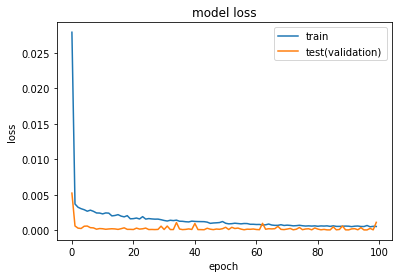

In [17]:
plt.plot(histories.history['loss'])
plt.plot(histories.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test(validation)'], loc='upper right')
plt.show()

## Making the predictions 

In [18]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

## Visualising the results

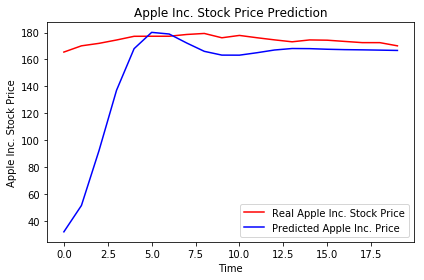

In [23]:
plt.plot(real_stock_price, color = 'red', label = 'Real Apple Inc. Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Apple Inc. Price')
plt.title('Apple Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Inc. Stock Price')
plt.legend()
plt.tight_layout()
plt.savefig('timesteps_{}.png'.format(timesteps))
plt.show()

## Model performance and Parameters Tuning
The following strategy will be used to improve the models: 
* Increase timesteps 
* Add more LSTM layers
* Increase number of neurons in each LSTM layer 
* Add stock prices of correlated companies with Apple Inc. as a new indicator in the training set

In [20]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
rmse

45.196020491379024

## Parameters Tuning: Log 
The following parameters have been experimented thus far. 
* 48.218127741254314 = 60 timesteps
* 45.196020491379024 = 120 timesteps

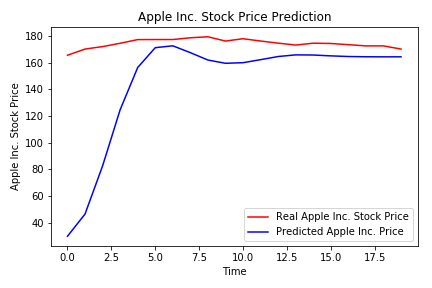

In [24]:
from IPython.display import Image
Image(filename='timesteps_60.png') 

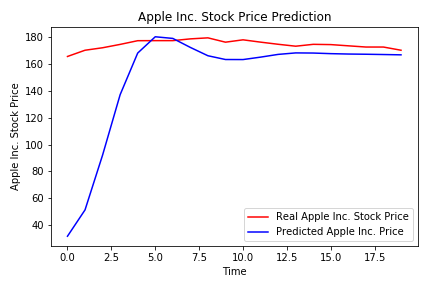

In [25]:
from IPython.display import Image
Image(filename='timesteps_120.png') 